In [21]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.dates as mdates
import numpy as np
from datetime import datetime
import pandas as pd
from matplotlib.animation import FuncAnimation
import geopandas as gpd


import threedigrid
from threedigrid.admin.gridresultadmin import GridH5ResultAdmin
from threedigrid.admin.gridadmin import GridH5Admin

import uuid

In [22]:
from __my_functions_flooddepth_houses import get_time_dimensions_flood
from __my_functions_flooddepth_houses import create_df_flooddepth_houses
from __my_functions_flooddepth_houses import create_sample_houses_withinZone
from __my_functions_flooddepth_houses import calculate_first_qth_arrival_and_maxdepth
from __my_functions_flooddepth_houses import plot_flooddepth_houses_in_zone

-----------

### paths

In [23]:
## flood results paths
# floodresults_path = '/Users/louiseklingen/Documents/TU/modelresults/modelresults_denhelder' 
floodresults_path = 'E:/projecten/P2019_1_DenHelderOverstroming/data_en_modellen/modelresults' 

In [24]:
general_path = 'E:/paper2_analysis/depth_arrival_zones'
figures_path = f'{general_path}/figures'
input_path = f'{general_path}/input'
output_path = f'{general_path}/output'

-----------------------------------

### laod result 

In [25]:
# scenario_name = 'scen2_napiek'
nr_zones_sampling = 89
samplesize_nr_houses_in_zone = 50


# scenario_name = 'scen1_voorpiek'
# simulation_name = 'lk_dh_test13_5verloop_2d'
# ## start_breach_time = '2000-01-01T18:00:00'
# start_breach_time = '2000-01-01T00:00:00'


scenario_name = 'scen2_napiek'
simulation_name = 'lk_dh_test14_5verloop_38h'
# start_breach_time = '2000-01-02T04:00:00'
start_breach_time = '2000-01-01T00:00:00'

In [26]:
zones_maxdepth_arrival_df = gpd.read_file(f'{output_path}/zones_maxdepth_arrival_df_{scenario_name}_{nr_zones_sampling}zones_{samplesize_nr_houses_in_zone}houses.geojson')
zones_maxdepth_arrival_df.head(2)


,BU_NAAM,AANT_INW,maxdepth,maxdepth_qt,arrival,geometry
0,Blauwe Keet,45,1.708696,1.561553,2000-01-01 02:00:04,"POLYGON ((112962.203 547568.188, 113580.000 54..."
1,'t Zand-West- en -Zuid,840,NaN,NaN,nan,"POLYGON ((112411.071 539578.531, 112435.289 53..."


In [27]:
## flood result files
netcdf_file = (f'{floodresults_path}/{simulation_name}/results_3di.nc')
gridadmin_file = (f'{floodresults_path}/{simulation_name}/gridadmin.h5')
gr = GridH5ResultAdmin(gridadmin_file , netcdf_file)
ga = GridH5Admin(gridadmin_file)
time_humanized, last_timestamp  = get_time_dimensions_flood(gr, start_breach_time)

rekentijd: 38.00862374799665 uur
aantal tijdstappen: 457
interval: 300.02, secondes = 5.0 min
 breach start time at: 2000-01-01 00:00:00


------------

<AxesSubplot:>

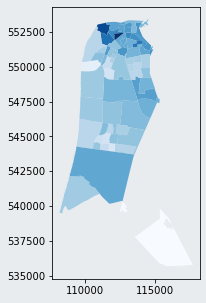

In [28]:
fig = plt.figure(figsize=(20, 5),facecolor='#e9ecef')
ax = fig.add_subplot(1, 1, 1)
ax.set_facecolor('#e9ecef')


# zones_maxdepth_arrival_df.plot(ax=ax, column = 'arrival', cmap= 'YlOrRd_r')
zones_maxdepth_arrival_df.plot(ax=ax, column = 'maxdepth', cmap= 'Blues')


## drop nan values

In [29]:
zones_maxdepth_arrival_df_dropna = zones_maxdepth_arrival_df.dropna()

In [30]:
# type(zones_maxdepth_arrival_df_dropna.arrival[10])

In [31]:
time_humanized[80]

datetime.datetime(2000, 1, 1, 6, 40, 4)

### change time to minutes

In [32]:
zones_maxdepth_arrival_df_dropna.head(2)

,BU_NAAM,AANT_INW,maxdepth,maxdepth_qt,arrival,geometry
0,Blauwe Keet,45,1.708696,1.561553,2000-01-01 02:00:04,"POLYGON ((112962.203 547568.188, 113580.000 54..."
2,Ooghduyne,170,1.162799,1.065256,2000-01-01 03:20:00,"POLYGON ((109646.602 546255.813, 109845.398 54..."


### flood depth threshold

In [33]:
#filter on depth
depth_threshold = 1.5
zones_maxdepth_threshold = zones_maxdepth_arrival_df_dropna[zones_maxdepth_arrival_df_dropna.maxdepth > depth_threshold]


### export to geojson

In [34]:
# export to geojson
zones_maxdepth_threshold.to_file(f'{output_path}/zones_maxdepth_threshold_{scenario_name}_{nr_zones_sampling}zones_{samplesize_nr_houses_in_zone}houses_tresh_{depth_threshold}m.geojson')


C:\Users\Louise\anaconda3\envs\geo\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'E:/paper2_analysis/depth_arrival_zones/output/zones_maxdepth_threshold_scen2_napiek_89zones_50houses_tresh_1.5m.geojson'

In [35]:
zones_maxdepth_threshold.AANT_INW.sum()

32380

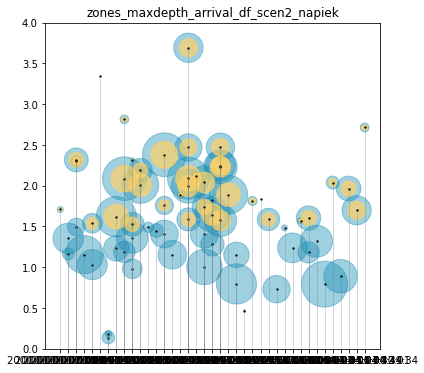

In [36]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(1, 1, 1)
# ax2 = fig.add_subplot(1, 2, 2)

df = zones_maxdepth_arrival_df_dropna.copy()
df_tr = zones_maxdepth_threshold.copy()


ax1.vlines(df.arrival, 0, df.maxdepth, linewidth= 1, color = '#70798c', alpha=0.3)
ax1.scatter(df.arrival, df.maxdepth,s = df.AANT_INW*0.8, alpha= 0.4, color = '#118ab2' )
ax1.scatter(df_tr.arrival, df_tr.maxdepth,s = df_tr.AANT_INW*0.3, alpha=0.7 , color= '#ffd166')
ax1.scatter(df.arrival, df.maxdepth,s = 1.7, alpha=1, c ='k' )

ax1.set_ylim(0,4)
ax1.set_title(f'zones_maxdepth_arrival_df_{scenario_name}') 


# ax1.set_ylim(0,4)
# print(df_tr.AANT_INW.sum())

plt.savefig(f'{figures_path}/zones_maxdepth_arrival_df_{scenario_name}_{nr_zones_sampling}zones_{samplesize_nr_houses_in_zone}houses_tr{depth_threshold}m.png', dpi=300)  
# plt.savefig(f'{figures_path}/zones_maxdepth_arrival_df_{scenario_name}_{nr_zones_sampling}.svg', dpi=300)  